# Modelo SRV

Este notebbok aplicará o algoritmo de SVR ao dataset obtido pelo xTB.

**Autor:** Edélio Gabriel Magalhães de Jesus.

<a id='sumario'></a>
## Sumário

- [1) Introdução](#intro)
  - [1.1) Support Vector Machine: Uma visão geral](#svm)
  - [1.2) Objetivo do notebook](#objetivo)
- [2) Desenvlvimento do modelo](#desenvolvimento)
  - [2.1) Bibliotecas necessárias](#bibliotecas)
  - [2.2) Leitura e primeiras visualizações do *dataset*](#leitura)
  - [2.3) Split dos dados](#split)
  - [2.4) Otimização do hiperparâmetros com o optuna](#optuna)
- [3) Treino e teste finais](#treino_teste_finais)
- [4) Interpretabilidade via SHAP](#interpretabilidade)
  - [4.1) O que é o SHAP?](#shap)
  - [4.2) Relação entre interpretabilidade e os modelos](#relacao)
- [5) Usando o SHAP](#usando_shap)
  - [5.1) Módulos necessários](#modulos)
  - [5.2) Avaliando o modelo](#avaliando_modelo)
  - [5.3) Summary plot](#summary)
  - [5.4) Bar plot](#barplot)
  - [5.5) Waterfall plot](#waterplot)
- [6) Conclusão](#conclu)
- [Referências](#ref)

<a id='intro'></a>
## 1) Introdução 

<a id='svm'></a>
### **1.1) Support Vector Machine: Uma Visão Geral**

![gif](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*2-EExC6mYeEMvtrw.gif)

**Support Vector Machine (SVM)** é um algoritmo de aprendizado supervisionado inicialmente desenvolvido para **classificação binária**. Seu objetivo é encontrar **o hiperplano ótimo** que separa os dados de duas classes em um espaço de \(n\) dimensões. Esse “ótimo” não significa apenas separar corretamente, mas sim **maximizar a margem**, isto é, a distância entre a fronteira de decisão e os pontos mais próximos a ela [1, 2, 3, 4]. Esse processo de maximização tem suporte da **Teoria de Aprendizado Estatístico (TAE)** [4, 5] - se quiser saber mais, clique [aqui](https://en.wikipedia.org/wiki/Statistical_learning_theory).

Esses pontos de cada classe que ficam mais próximos do hiperplano recebem o nome de **vetores de suporte** (*support vectors*) e são os elementos fundamentais que definem a solução final [1, 2, 3].  

Embora tenha surgido para problemas binários [4], o SVM pode ser estendido a **classificação multiclasse**. As duas estratégias mais comuns são [6]:  
- **One-vs-Rest (OvR)**: treina um classificador para cada classe contra todas as outras.  
- **One-vs-One (OvO)**: treina classificadores para cada par de classes e usa votação para decidir a predição final.  

Com o tempo, o conceito foi ampliado: hoje podemos considerar o **SVM** como sendo uma **família de modelos** baseados nessa mesma ideia de margem máxima, mas aplicados a diferentes contextos (classificação linear, não linear, regressão e até detecção de anomalias) [6].  

No **scikit-learn**, as principais variantes são:  
- **`SVC`** – Support Vector Classification, usado em classificação (linear ou com kernels).  
- **`LinearSVC`** – versão otimizada para problemas lineares de alta dimensionalidade.  
- **`NuSVC`** – alternativa ao `SVC` que usa o parâmetro `nu` em vez de `C` para controlar o número de vetores de suporte.  
- **`SVR`** – Support Vector Regression, aplica o mesmo princípio à regressão.  
- **`OneClassSVM`** – usado para detecção de anomalias/outliers. 


<a id='objetivo'></a>
### **1.2) Objetivo do notebook**

Neste notebook, implementaremos o algoritmo **`SVR`** em um modelo para resolver a tarefa de **regressão supervisionada**.

[Voltar ao topo](#sumario)

<a id='desenvolvimento'></a>
## 2) Desenvolvendo o modelo

<a id='bibliotecas'></a>
### **2.1) Bibliotecas e métodos necessários**

Antes de tudo, precisamos importar alguns módulos e funções específicas. São quatro bibliotecas principais:

1) **_pandas_**: para criação e manipulação de dataframes;  
2) **_numpy_**: para operações matemáticas e tratamento de arrays;  
3) **_plotly_**: para geração de gráficos interativos;  
4) **_sklearn_**: para implementação de modelos e ferramentas de *Machine Learning* (como divisão de dados, normalização e validação cruzada).  
5) **optuna**: para otimização dos hiperparâmetros

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from optuna import create_study
from optuna.samplers import TPESampler, GPSampler
from optuna.pruners import HyperbandPruner
from optuna import Trial
from optuna.exceptions import TrialPruned
from concurrent.futures import ThreadPoolExecutor
from optuna import load_study
import warnings
from sklearn.exceptions import ConvergenceWarning
import plotly.graph_objects as go
import plotly.express as px


c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='leitura'></a>
### **2.2) Leitura e primeiras visualizações do *dataset***

In [2]:
SEMENTE_ALEATORIA = 367

df = pd.read_csv('../dataset_processing/xtb_dataset.csv').sample(frac=0.1, random_state=SEMENTE_ALEATORIA)

df.describe()

,Dipole,E_HOMO,E_LUMO,gap_HOMO-LUMO,ZPE,H,U,U0,G,Delta
count,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000,12916.000000
mean,3.202531,-10.474635,-5.757171,-4.717464,0.143381,-26.842614,-26.843558,-26.994638,-26.883299,-13.484293
std,1.757499,0.593678,2.320549,2.264760,0.032783,2.142806,2.142806,2.155905,2.144145,2.155905
min,0.000000,-15.970300,-11.174700,-14.350000,0.012600,-34.330713,-34.331658,-34.452850,-34.374238,-33.305032
25%,1.931000,-10.839500,-7.431775,-5.836725,0.120520,-28.239447,-28.240391,-28.387537,-28.280993,-14.568182
50%,2.983000,-10.507150,-6.347100,-4.095400,0.142961,-27.090120,-27.091064,-27.271079,-27.130717,-13.207853
75%,4.232000,-10.137975,-4.424275,-3.222800,0.165368,-25.783072,-25.784016,-25.910750,-25.822526,-12.091394
max,26.537000,-6.421500,2.805200,-0.011700,0.268030,-7.144001,-7.144946,-7.173899,-7.168830,-6.026081


A documentação disponível no *sklearn* [6] indica que, para conjunto de dados muito grandes, o algoritmo *LinearSVR* pode ser mais eficiente em termos de memória e tempo de execução. Contudo, é necessário ter certeza que a relação entre as variáveis é linear. Para isso, podemos conferir observando a `Matriz de Correlação`.

---

A **Matriz de Correlação** $\mathbf{C}$ é uma matriz simétrica contendo todas as possíveis correlações computadas para cada $x_i$, dois a dois (as correlações são os coeficientes de correlação de Pearson). Supondo que temos $(x_1, x_2, x_3)$, a matriz de correlação será:

$$
\mathbf{C} =
\left[\begin{array}{ccc}
\mathrm{Corr}(x_{1},x_{1})&\mathrm{Corr}(x_{1},x_{2})&\mathrm{Corr}(x_{1},x_{3})\\
\mathrm{Corr}(x_{2},x_{1})&\mathrm{Corr}(x_{2},x_{2})&\mathrm{Corr}(x_{2},x_{3})\\
\mathrm{Corr}(x_{3},x_{1})&\mathrm{Corr}(x_{3},x_{2})&\mathrm{Corr}(x_{3},x_{3})\\
\end{array} \right].
$$

---

In [3]:
corr = df.corr()

fig = px.imshow(corr, text_auto=True, aspect="auto",
                title="Matriz de Correlação")
fig.show()


Correlação próximas de **1** ou **-1** indicam uma forte relação linear entre a variável independente $X$ e o *target*.  
Com base nisso, observa-se que **apenas 4 dos 9 atributos** apresentam essa característica.  

Isso sugere que o conjunto de dados possui **relações predominantemente não lineares**, o que torna **inadequado o uso do algoritmo *LinearSVR*** — uma versão mais simples e menos custosa do *Support Vector Regressor*.  

Assim, **optamos pelo uso do *SVR* clássico**, que permite explorar diferentes *kernels* capazes de capturar **padrões mais complexos** nas relações entre as variáveis.

<a id='split'></a>
### **2.3) Split dos dados**

A etapa de *split* no tratamento de dados consiste em `dividir` o conjunto de dados disponível em subconjuntos distintos: *`treinamento`* e *`teste`*. Essa divisão é importante para que o modelo de aprendizado de máquina seja treinado em uma parte dos dados e, posteriormente, avaliado em dados que ele nunca viu, garantindo uma medição justa de seu desempenho e evitando o *overfitting* - o ajuste excessivo aos dados de treinamento - e o *underfitting* - subestimação dos dados.

In [4]:

TAMANHO_TESTE = 0.2
SEMENTE_ALEATORIA = 367

X = df.drop(columns=['Delta'])
y = df['Delta']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

[Voltar ao topo](#sumario)

<a id='optuna'></a>
### **2.4) Otimização dos hiperparâmetros com o optuna**

#### **`Modelo e espaço de busca`**

A função `cria_instancia_modelo` abaixo serve para criar uma instância do modelo escolhido. Esta função recebe um objeto tipo *trial*; do `optuna`.

Observe que o dicionário `parametros` dentro desta função tem como chaves os nomes dos argumentos do modelo. Os valores dos argumentos, por sua vez, podem ser sorteados com as funções

-   `trial.suggest_int` (para números inteiros)
-   `trial.suggest_float` (para números reais) e
-   `trial.suggest_categorical` (para dados categóricos).

São com estas funções que delimitamos o **espaço de busca** dos hiperparâmetros do modelo.

Além dos parâmetros do modelo, estamos permitindo que o *optuna* decida se irá realizar os pré-processamentos de normalizar os dados (via *StandScaler*), reduzir a dimensionalidade (via *PCA*) e selecionar os atributos (via *SFS*).

In [ ]:

def criar_instancia_modelo(trial, n_features):
    # Escolha do kernel
    kernel_escolhido = trial.suggest_categorical("kernel", ["rbf", "poly", "linear"])

    # gamma (contínuo para não lineares)
    gamma = trial.suggest_float("gamma", 1e-2, 10, log=True) if kernel_escolhido in ["rbf", "poly"] else "scale"

    # coef0 (só para poly)
    coef0 = trial.suggest_float("coef0", 0.1, 1, log=True) if kernel_escolhido == "poly" else 0

    # Parâmetros do SVR base
    parametros_svr = {
        "C": trial.suggest_float("C", 1e-1, 1e2, log=True),
        "epsilon": trial.suggest_float("epsilon", 1e-2, 1, log=True),
        "kernel": kernel_escolhido,
        "degree": trial.suggest_int("degree", 2, 4) if kernel_escolhido == "poly" else 3,
        "gamma": gamma,
        "coef0": coef0,
        "max_iter": 500000
    }

    # Flags do trial
    usar_std = trial.suggest_categorical("usar_std", [True, False])   
    usar_pca = trial.suggest_categorical("usar_pca", [True, False])
    usar_sfs = trial.suggest_categorical("usar_sfs", [True, False])

    steps = []

    # Pipeline base
    if usar_std:
        steps.append(("normalizador", StandardScaler()))

    # SFS opcional
    usar_sfs = trial.suggest_categorical("usar_sfs", [True, False])

    if usar_sfs:
        forward = trial.suggest_categorical("sfs_forward", [True, False])
        n_features_to_select = trial.suggest_int("n_features_to_select", 1, 8)

        # Correção automática
        if n_features_to_select >= n_features:
            n_features_to_select = max(1, n_features - 1)

        steps.append((
            "sfs",
            SequentialFeatureSelector(
                estimator=SVR(**parametros_svr),
                n_features_to_select=n_features_to_select,
                direction="forward" if forward else "backward",
                scoring="neg_root_mean_squared_error",
                cv=3,
                n_jobs=1
            )
        ))

        # PCA opcional
        if usar_pca and kernel_escolhido in ["rbf", "poly"]:
            n_comp = trial.suggest_float("variancia_pca", 0.85, 0.95)
            steps.append(("pca", PCA(n_components=n_comp, random_state=SEMENTE_ALEATORIA)))

    # Regressor final
    steps.append(("regressor", SVR(**parametros_svr)))
    modelo = Pipeline(steps=steps)
    return modelo

#### **`Função objetivo`**

A **função objetivo** em um problema de otimização é responsável por calcular a **métrica de desempenho** que será minimizada ou maximizada durante o processo.  

Neste caso, a métrica escolhida é o **RMSE (Root Mean Squared Error)**, obtido por meio de **validação cruzada aninhada**.

---

**Observação:**  
O *Python* (ou mais especificamente, algumas funções do `scikit-learn`) retorna valores **negativos** para métricas de erro quando configuradas para maximização.  
Por isso, é necessário **multiplicar por -1** antes de calcular a média dos valores de RMSE, garantindo que o algoritmo do Optuna minimize corretamente o erro.


In [6]:
def funcao_objetivo(trial, X, y, NUM_FOLDS=5):
    n_features = X.shape[1]
    modelo = criar_instancia_modelo(trial, n_features=n_features)

    cv = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEMENTE_ALEATORIA)
    rmse_folds = []

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)

        rmse_folds.append(rmse)

        # Reporta progresso ao Optuna
        trial.report(np.mean(rmse_folds), step=i + 1)
        if trial.should_prune():
            raise TrialPruned()

    return np.mean(rmse_folds)

Vamos explorar um pouco mais sobre o uso da `Validação Cruzada Aninhada`.

---

A validação cruzada aninhada é uma técnica alternativa para avaliar o desempenho de um modelo de machine learning **quando também estamos ajustando hiper‑parâmetros** [7].  
Ela funciona por meio de **dois laços (loops)**:  
- **Laço externo (outer loop):** divide os dados em K folds para estimar o erro de generalização final do modelo.  
- **Laço interno (inner loop):** para cada subdivisão do laço externo, realiza uma nova validação cruzada (por exemplo usando `GridSearchCV`) para ajustar hiper‑parâmetros com os dados de treino desse fold externo.  

**Por que usar?**  
Se usarmos apenas uma validação cruzada simples para escolher hiper‑parâmetros *e* avaliar desempenho com o mesmo conjunto, corremos risco de obter estimativas excessivamente otimistas. A validação cruzada aninhada separa claramente a fase de seleção de modelos (*inner loop*) da fase de avaliação (*outer loop*) proporcionando estimativas menos enviesadas, minimizando o efeito de *overffiting*.

---

As duas funções abaixo realizam esse processo.


In [7]:
def cv_aninhado_fold(fold_idx, X, y, outer_splits, inner_splits, n_trials, pasta_estudos):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=SEMENTE_ALEATORIA)

    for fold, (idx_train, idx_test) in enumerate(outer_cv.split(X, y)):
        if fold != fold_idx:
            continue

        print(f"\n Fold externo {fold + 1}/{outer_splits}")
        X_treino, X_teste = X.iloc[idx_train], X.iloc[idx_test]
        y_treino, y_teste = y.iloc[idx_train], y.iloc[idx_test]

        caminho_db = os.path.join(pasta_estudos, f"svr_fold_{fold + 1}.db")

        def inner_objective(trial):
            return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS=inner_splits)

        study = create_study(
            study_name=f"krr_fold_{fold + 1}",
            direction="minimize",
            sampler=TPESampler(),
            pruner=HyperbandPruner(min_resource=1, max_resource=inner_splits, reduction_factor=2),
            storage=f"sqlite:///{caminho_db}",
            load_if_exists=True
        )

        # Ensaios iniciais para diversificar
        study.enqueue_trial({"usar_std": False})
        study.enqueue_trial({"usar_std": True})
        study.enqueue_trial({"usar_pca": False})
        study.enqueue_trial({"usar_pca": True})
        study.enqueue_trial({"usar_sfs": False})
        study.enqueue_trial({"usar_sfs": True})

        study.optimize(inner_objective, n_trials=n_trials, n_jobs=1, show_progress_bar=False)

        print("Melhores hiperparâmetros encontrados:")
        print(study.best_params)

        melhor_modelo = criar_instancia_modelo(study.best_trial, n_features=X_treino.shape[1])
        melhor_modelo.fit(X_treino, y_treino)

        y_pred = melhor_modelo.predict(X_teste)
        rmse_teste = root_mean_squared_error(y_teste, y_pred)
        print(f"→ RMSE de teste externo (fold {fold + 1}): {rmse_teste:.4f}")
        return rmse_teste

Esta função, em esecífico, faz com que os *outer trials* sejam executados paralelamente, cada um com seu próprio arquivo *.db*, a fim de buscar diminuir o tempo de execução.

In [8]:
def cv_aninhado(X, y, outer_splits=3, inner_splits=5, n_trials=10, pasta_estudos="estudos_optuna_svr_final"):
    os.makedirs(pasta_estudos, exist_ok=True)
    outer_scores = []

    with ThreadPoolExecutor(max_workers=outer_splits) as executor:
        futures = [
            executor.submit(cv_aninhado_fold, fold, X, y, outer_splits, inner_splits, n_trials, pasta_estudos)
            for fold in range(outer_splits)
        ]
        for f in futures:
            outer_scores.append(f.result())

    print("\n========================")
    print("Resultados do Nested CV:")
    print(f"RMSE médio: {np.mean(outer_scores):.4f}")
    print(f"Desvio padrão: {np.std(outer_scores):.4f}")
    print("========================")

    return outer_scores

#### **`Realizando o estudo`**

In [ ]:
resultados = cv_aninhado(
    X_treino, y_treino,
    outer_splits=3,
    inner_splits=5,
    n_trials=200
)

O estudo foi realizado, agora precisamos obter o melhor estudo dentre todos os estudos de cada *fold* externo e, posteriormente, o melhor entre os melhores.

In [21]:
pasta_estudos = "estudos_optuna_svr_final"
arquivos_db = [f for f in os.listdir(pasta_estudos) if f.endswith(".db")]

print("Arquivos .db encontrados:")
for f in arquivos_db:
    print("-", f)


Arquivos .db encontrados:
- krr_fold_1.db
- svr_fold_3.db
- svr_fold_2.db
- svr_fold_1.db


In [25]:
resultados = []

for arquivo in arquivos_db:
    caminho = os.path.join(pasta_estudos, arquivo)
    # Ajuste conforme descoberto no passo anterior
    study_name = arquivo.replace("svr_fold", "krr_fold").replace(".db", "")
    
    try:
        study = load_study(study_name=study_name, storage=f"sqlite:///{caminho}")
        best_trial = study.best_trial
        
        print(f"✅ {study_name}")
        print(f"  Melhor valor: {best_trial.value:.7f}")
        print(f"  Parâmetros: {best_trial.params}\n")
        
        resultados.append({
            "fold": study_name,
            "melhor_valor": best_trial.value,
            "params": best_trial.params
        })
    except Exception as e:
        print(f"Não foi possível carregar {study_name}: {e}")

# Criar resumo
if resultados:
    df = pd.DataFrame(resultados)
    display(df)
    print(f"RMSE médio: {np.mean(df['melhor_valor']):.7f}")
    print(f"Desvio padrão: {np.std(df['melhor_valor']):.7f}")
else:
    print("Nenhum estudo pôde ser carregado.")


⚠️ Não foi possível carregar krr_fold_1: 'Record does not exist.'
✅ krr_fold_3
  Melhor valor: 0.0024869
  Parâmetros: {'kernel': 'linear', 'C': 23.069035874199496, 'epsilon': 0.01005448848886116, 'usar_std': True, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 3}

✅ krr_fold_2
  Melhor valor: 0.0027495
  Parâmetros: {'kernel': 'linear', 'C': 3.3641779284302955, 'epsilon': 0.010043369307283195, 'usar_std': False, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 4}

✅ krr_fold_1
  Melhor valor: 0.0028444
  Parâmetros: {'kernel': 'linear', 'C': 3.0724426569117047, 'epsilon': 0.010002848957040978, 'usar_std': False, 'usar_pca': True, 'usar_sfs': True, 'sfs_forward': True, 'n_features_to_select': 4}



,fold,melhor_valor,params
0,krr_fold_3,0.002487,"{'kernel': 'linear', 'C': 23.069035874199496, ..."
1,krr_fold_2,0.002749,"{'kernel': 'linear', 'C': 3.3641779284302955, ..."
2,krr_fold_1,0.002844,"{'kernel': 'linear', 'C': 3.0724426569117047, ..."


RMSE médio: 0.0026936
Desvio padrão: 0.0001512


In [26]:
# df já contém os melhores trials de cada fold
melhor_fold = df.loc[df['melhor_valor'].idxmin()]  # menor RMSE
print("Melhor fold:", melhor_fold['fold'])
print("Melhor valor:", melhor_fold['melhor_valor'])
print("Melhores parâmetros:", melhor_fold['params'])


Melhor fold: krr_fold_3
Melhor valor: 0.0024869105540732466
Melhores parâmetros: {'kernel': 'linear', 'C': 23.069035874199496, 'epsilon': 0.01005448848886116, 'usar_std': True, 'usar_pca': False, 'usar_sfs': True, 'sfs_forward': False, 'n_features_to_select': 3}


O melhor modelo encontrado aplicou os seguintes processos e parâmetros:

- Aplicar normalização: com StandScaler();
  
- Aplicar seleção de atributos: com SequencialFeatureSelection(), selecioando apenas 3 features e no modo *backward* - retirando ao invés de acrescentar;

- Aplicar o SVR com os seguintes parâmetros:

  - **Kernel: linear**  
    O kernel linear indica que o modelo busca uma relação aproximadamente linear entre as features selecionadas e a variável alvo, evitando complexidade desnecessária de kernels não lineares.
  
  - **C: 23.07**  
    O parâmetro `C` controla a penalização por erros de previsão. Um valor alto, como 23, indica que o modelo penaliza fortemente desvios maiores da linha de regressão, buscando se ajustar mais aos dados de treinamento. 
  
  - **Epsilon: 0.01005**  
    O parâmetro `epsilon` define uma faixa de tolerância em torno da função alvo dentro da qual erros não são penalizados. Um valor pequeno como 0.01 faz o modelo tentar se ajustar muito próximo aos pontos de dados, buscando alta precisão nas previsões, mas também aumentando sensibilidade a ruídos.

Embora tenhamos confirmado que nem todas as *features* tinham relações lineares com o *target*, na etapa de seleção de atributo, o melhor desempenho foi somente com 3 dos 9.


[Voltar ao topo](#sumario)

<a id='treino_teste_finais'></a>
## 3) Treino e teste finais

In [6]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

TAMANHO_TESTE=0.2
df_final = pd.read_csv('../dataset_processing/xtb_dataset.csv').sample(frac=0.1, random_state=SEMENTE_ALEATORIA)


X = df_final.drop(columns=['Delta'])
y = df_final['Delta']


# Divisão dos dados
X_treino_final, X_teste_final, y_treino_final, y_teste_final = train_test_split(
    X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

# Modelo SVR com os melhores parâmetros
svr_model = SVR(
    kernel='linear',
    C=23.069035874199496,
    epsilon=0.01005448848886116
)

# Sequential Feature Selector com os mesmos parâmetros
sfs = SequentialFeatureSelector(
    estimator=SVR(
        kernel='linear',
        C=23.069035874199496,
        epsilon=0.01005448848886116
    ),
    n_features_to_select=3,
    direction='backward'  # sfs_forward=False -> backward
)

# Pipeline completo
pipe_final = Pipeline([
    ("normalizador", StandardScaler()),  # usar_std=True
    ("seletor", sfs),
    ("estimator", svr_model)
])

# Treinamento
pipe_final.fit(X_treino_final, y_treino_final)

# Recuperar nomes das features selecionadas
selected_features = X_treino_final.columns[sfs.get_support()]
print("Features selecionadas:", list(selected_features))


Features selecionadas: ['Dipole', 'ZPE', 'G']


Aqui, confirmamos quais features foram selecionadas: **Dipole**, **ZPE**, **G**.

---

Vamos seguir com o teste, via validação cruzada.

In [7]:
# Avaliar no conjunto de teste
from sklearn.metrics import mean_squared_error
y_pred = pipe_final.predict(X_teste_final)
rmse_teste = np.sqrt(mean_squared_error(y_teste_final, y_pred))

print("RMSE de teste:", rmse_teste)

RMSE de teste: 0.0028451222664458093


Tiveoms um RMSE de grandeza na ordem de $10^{-3}$, o que faz sentido, visto que nosso baseline foi de $\approx 2$.

<a id='interpretabilidade'></a>
## 4) Interpretabilidade via SHAP

<a id='shap'></a>
### **4.1) O que é o *SHAP***

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

<a id='relacao'></a>
### **4.2) Relação com a interpretabilidade de modelos**

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

[Voltar ao topo](#sumario)

<a id='usando_shap'></a>
## 5) Usando o SHAP

<a id='modulos'></a>
### **5.1) Módulos necessários**

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

In [9]:
import shap

<a id='avaliando_modelo'></a>
### **5.2 Avaliando o melhor modelo**

Para analisar a interpretabilidade utilizareoms o modelo vencedor encontrado pelo *Optuna* - já instanciado na seção anterior.

**Observação importante:** O *SHAP* não aceita um pipeline completo como entrada, ele requer um modelo final ou uma função de predição. 

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`SVR`), mas também inclui todas as etapas de pré-processamento do pipeline, como `StandardScaler`, `SFS` ou `PCA`. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


In [10]:
# Extrair os componentes já ajustados
scaler = pipe_final.named_steps["normalizador"]
sfs = pipe_final.named_steps["seletor"]
svr_model = pipe_final.named_steps["estimator"]

# Aplicar as transformações (usando os objetos já fitados)
X_treino_scaled = scaler.transform(X_treino_final)
X_treino_sel = sfs.transform(X_treino_scaled)

X_teste_scaled = scaler.transform(X_teste_final)
X_teste_sel = sfs.transform(X_teste_scaled)

# Explainer rápido para SVR linear
explainer = shap.LinearExplainer(svr_model, X_treino_sel)
shap_values = explainer(X_teste_sel)



Agora, vamos aos *plots*!

<a id='summary'></a>
### **5.3 Summary plot**

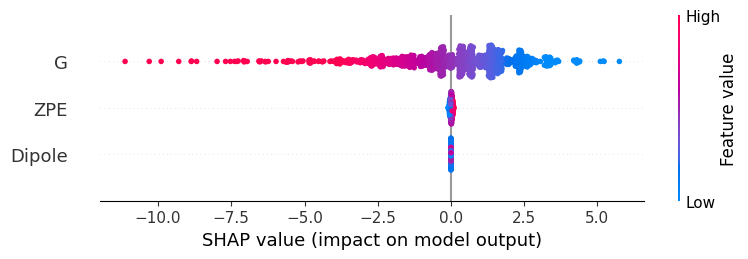

In [11]:
shap.summary_plot(shap_values.values, features=X_teste_sel, feature_names=selected_features)

Antes de tudo, perceba novamente que o melhor modelo resultou em uma seleção de apenas 3 dos 9 atributos do conjunto de dados original.

---

O gráfico acima é um **SHAP summary plot**, uma forma de visualizar a importância e o efeito das variáveis em um modelo preditivo.  
Cada ponto representa uma observação (amostra do conjunto de dados), e sua posição no eixo horizontal indica o **impacto da feature no output do modelo** — isto é, o quanto aquela variável contribuiu para aumentar ou diminuir a predição.

O gráfico acima representa o impacto das três *features* — **G**, **ZPE** e **Dipole** — sobre a saída do modelo, medido pelos valores SHAP (*SHapley Additive exPlanations*).  
Cada ponto representa uma amostra, com a cor indicando o valor da *feature* (rosa = alto, azul = baixo).


`Análise geral`

- **Eixo X (SHAP value)**: mostra o quanto cada *feature* contribui para aumentar (valores positivos) ou diminuir (valores negativos) a predição do modelo.
- **Eixo Y (features)**: ordena as variáveis por importância média (impacto absoluto dos valores SHAP).
- **Cores**: representam o valor real da *feature* — tons quentes (rosa/vermelho) indicam valores altos, e tons frios (azul) indicam valores baixos.

`Interpretação por *feature*`

1. **G (energia de gibbs)**  
   - É a variável mais importante do modelo.  
   - Observa-se uma ampla dispersão de valores SHAP, especialmente negativos, indicando forte impacto sobre a saída.  
   - Valores altos de G (rosa) tendem a diminuir fortemente a predição, enquanto valores baixos (azul) têm efeito oposto, aumentando-a.

2. **ZPE (Zero Point Energy)**  
   - Possui impacto pequeno e concentrado próximo de zero.  
   - As variações dessa *feature* não alteram significativamente o resultado do modelo.  
   - Isso sugere que o momento dipolar tem baixa relevância para o fenômeno sendo modelado.

3. **Dipole (Momento dipole)**  
   - Também apresenta impacto mínimo, similar ao do *ZPE*.  
   - A distribuição estreita ao redor de zero indica baixa sensibilidade do modelo a essa variável.

Assim, o modelo baseia-se fortemente na variável **G** para suas previsões, enquanto **Dipole** e **ZPE** contribuem muito pouco.  
Em termos físicos, isso indica que a **enegia de gibbs** é o fator determinante no comportamento que o modelo está aprendendo, possivelmente refletindo uma relação direta com o alvo energético previsto.

**Insight científico:**  
A dominância de G evidencia que o SVR linear captou uma **relação energética essencial**, provavelmente associada à estabilidade termodinâmica ou ao equilíbrio molecular, enquanto variáveis de natureza mais sutil — como ZPE e momento dipolar — têm efeito marginal dentro do regime linear aprendido.  

<a id='barplot'></a>
### **5.4) Bar plot**

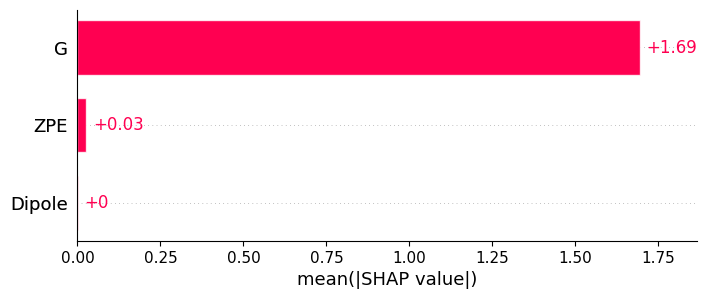

In [17]:
shap.plots.bar(shap_values)

O gráfico acima mostra a **importância média das variáveis** no modelo, calculada pela média dos valores absolutos de SHAP (`mean(|SHAP value|)`).  
Ele representa, em termos quantitativos, **o quanto cada *feature* contribui em média para as variações das previsões**.

`Estrutura do gráfico`
- **Eixo X:** magnitude média dos valores SHAP — quanto maior, maior o impacto da *feature* no resultado.  
- **Eixo Y:** lista das *features* avaliadas.  
- **Cor e anotação à direita:** indicam o valor numérico do impacto médio.

`Interpretação detalhada`

1. **G (energia de gibbs)**  
   - Apresenta o maior valor médio de |SHAP| (≈ **3.69**), destacando-se de forma absoluta em relação às demais.  
   - Isso confirma que **G é a variável dominante** na determinação das previsões do modelo.  
   - Em termos práticos, pequenas variações em G produzem grandes alterações na saída prevista, reforçando sua relevância física.

2. **ZPE (Zero Point Energy)**  
   - Possui impacto médio muito baixo (**≈ 0.03**).  
   - O modelo praticamente ignora essa variável durante as predições.

3. **Dipole (Momento de dipolo)**  
   - Apresenta contribuição média nula (**≈ 0**), indicando irrelevância para o modelo.

Assim, pelos resultados, modelo se apoia **quase exclusivamente na variável G**, enquanto as demais *features* não exercem influência mensurável sobre as predições.  
Esse resultado reforça a evidência observada no *summary plot*: **G domina a explicação das variações do alvo**, e a inclusão de *Dipole* e *ZPE* não melhora a capacidade preditiva do modelo de maneira muito significativa.

<a id='waterplot'></a>
### **5.5) Waterfall plot**

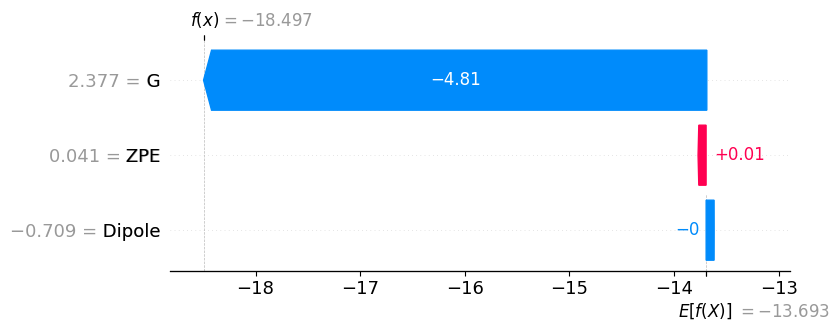

In [18]:
shap.plots.waterfall(shap_values[0])

O gráfico acima é um **waterfall plot** do SHAP, que mostra **como cada *feature* contribui individualmente** para a predição de uma amostra específica do modelo.

`Estrutura do gráfico`

- **E[f(X)] = 13.693** → é o valor médio das predições do modelo (baseline).  
- **f(x) = -18.497** → é a predição final para esta amostra.  
- As barras mostram como cada *feature* desloca o valor da predição em relação à média.  
  - **Azul**: contribuição negativa (reduz o valor previsto).  
  - **Vermelho**: contribuição positiva.

`Interpretação`

1. **G = 2.377 → impacto = -4.81**  
   - É a variável que mais influenciou a predição.  
   - Seu valor negativo levou a uma **redução de 2.27 unidades** no resultado final em relação à média do modelo.  
   - Isso reforça o padrão visto nos gráficos anteriores: **valores baixos de U0** reduzem fortemente a saída predita.

2. **ZPE = 0.041 → impacto ≈ +0.01**  
   - O momento dipolar praticamente **não alterou a predição**.  
   - Sua influência é foi muito baixa nesse caso.

3. **Dipolo = -0.709 → ≈ 0**  
   - Não contribuiu de forma relevante para o resultado final.

A predição **f(x) = -18.497** resulta principalmente da influência da variável **G**, que deslocou a estimativa média (43.93) para baixo.  
As demais *features* (**Dipole** e **ZPE**) tiveram efeito praticamente irrelevante sobre a saída.

<a id='conclu'></a>
## 6) Conclusão

Neste notebook conseguimos explorar o conceito de **interpretabilidade** em modelo de Machine Learning.

Utilizando o módulo *SHAP*, analisamos o melhor modelo do algoritmo *Kernel Ridge Regression* obtido pelo estudo via *optuna*, explorando aspectos quantitativos e qualitativos, compreeendendo melhor como os atributos selecionados contruiram indidual e coletivamente para as previsões.

Compreender como modelos de ML realizam suas previsões está se tornado cada vez mais almejado, principalmente em contextos onde a simples predição não é suficiente - como em diagnósticos clínicos, nos quais é importante entender como se chegou a determinada conclusão.

<a id='ref'></a>
## Referências

[1] **Livro**: RASCHKA, Sebastian; MIRJALILI, Vahid. *Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2*. 3. ed. Packt, [s.d.].  

[2] **Vídeo** do canal StatQuest with Josh Starmer - [Support Vector Machines Part 1 (of 3): Main Ideas!!!](https://youtu.be/efR1C6CvhmE?si=yfCtwqnRPt1FEO1O)

[3] **Vídeo** do canal Hashtag Programação - [SVM (Support Vector Machine) - Algoritmos de Aprendizado de Máquinas](https://youtu.be/Y-WFZd9_gtE?si=5CMIM6krA9kQBNNy)

[4] **Livro**: FACELI, Katti; LORENA, et al.. Inteligência artificial: uma abordagem de aprendizado de máquina. 2. ed. Rio de Janeiro: LTC, 2021. 400 p.

[5] **Site** Wikipedia - [Teoria de Aprendizado Estatístico](https://en.wikipedia.org/wiki/Statistical_learning_theory)

[6] **Documentação** do sklearn - [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#svm)

---

Tudo sobre o SHAP foi baseado nestas referências:


LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317
. Acesso em: 24 out. 2025.

LUNDBERG, Scott; LEE, Su-In. SHAP – Welcome to the SHAP documentation. 2018 (?). Disponível em: https://shap.readthedocs.io/en/latest/
. Acesso em: 24 out. 2025.

AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability
. Acesso em: 24 out. 2025.

[Voltar ao topo](#sumario)